## Tutorial for AVped-Aware

In [1]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
import torch.nn as nn
import random
from tqdm import tqdm
import torch.optim as optim
from dataloader.avped_dataloader_tutorial import *
from network.avped import *
from utils import loss,visualization,metrics
%matplotlib inline
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## AV-PedAware: Self-Supervised Audio-Visual Fusion for Dynamic Pedestrian Awareness


### Load the data
Due to the privacy issue, We just release some of the data at this time. 

In addition, the released data is collected by a mic-array with 8-channels mic, which is a little different from the paper. Each audio data is 0.2s len. The sampling rate is 48000hz, therefore, each audio data is in the shape of (9600,8). Also, we are trying to collecting more data with better audio collection equipment and make it public. 

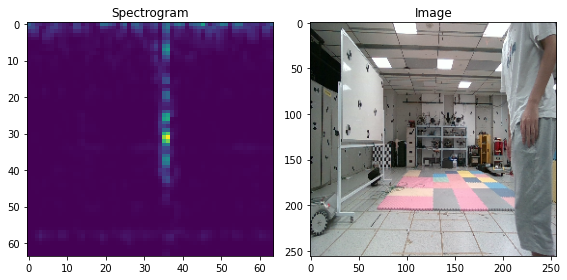

In [3]:
 # The path of the dataset
root = '/Data'
# The path for the annotation file 
train_anno_path = "/Data/annotation/anotation_train_all/trainval.txt"
val_anno_path   = "/Data/annotation/anotation_test_all/trainval.txt"

with open(train_anno_path, "r") as f:
    train_anno = f.readlines()

with open(val_anno_path, "r") as f:
    val_anno = f.readlines()

"""
dark_aug represents the whether dark_augmentation is deployed on the input image:
0: no augmentation
1: Random augmentation:60% change get a strong augmented image, 40% no augmentation
>=2: Constant augmentation, with the increase of the value, the augmentation will be stronger
"""

avped_traindataset = AVpedLoader(train_anno,root,dark_aug=1)
avped_valdataset = AVpedLoader(val_anno,root,dark_aug=1,testing=1) # testing set to 1 to get lidar data

train_dataloader = DataLoader(avped_traindataset,32, shuffle=True, num_workers=8, drop_last=True)
val_dataloader = DataLoader(avped_valdataset, 32, shuffle=True, num_workers=8, drop_last=True)

index = 0
# Randomly select an index
spec,image,gt,detect,segment= avped_traindataset.__getitem__(index)
image = (image.numpy()+1)*127.5/255

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(spec.numpy()[0], aspect='auto')
plt.title("Spectrogram")

plt.subplot(1, 2, 2)
plt.imshow(np.transpose(image, (1, 2, 0)), aspect='auto')
plt.title("Image")
plt.tight_layout()
plt.show()

### Load the model

In [4]:
model = FusionNet(dropout_rate=0.2).to(device)

### Model training
This tutorail shows the training and inference workflow for audio-visual input with segmentation task

In [5]:
def train_model(model, train_dataloader, optimizer, loss_fn, cls_loss, cls_loss2, device):
    model.train()
    train_loss = 0
    for data in tqdm(train_dataloader, total=len(train_dataloader), unit='batch'):
        spec, image, gt, detect, segment = [d.to(device) for d in data]
        segment = segment.long()
        optimizer.zero_grad()
        p, d, s = model(spec, image)
        loss_detect = cls_loss(d, detect)
        loss_seg = cls_loss2(s, segment)
        loss_position = loss_fn(p, gt)
        loss = loss_position + loss_detect*0.5 + loss_seg*0.3
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(train_dataloader)

def validate_model(model, val_dataloader, loss_fn, cls_loss, cls_loss2, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data in val_dataloader:
            spec, image, gt, detect, segment,lidar = [d.to(device) for d in data]
            segment = segment.long()
            p, d, s = model(spec, image)
            loss_detect = cls_loss(d, detect)
            loss_seg = cls_loss2(s, segment)
            loss_position = loss_fn(p, gt)
            loss = loss_position + loss_detect*0.5+ loss_seg*0.3
            val_loss += loss.item()
    return val_loss / len(val_dataloader)

In [6]:
train_epoch = 30
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999))
loss_fn  = loss.regression_loss
weights = torch.tensor([1.0,3.0]).to(device)
cls_loss  = torch.nn.CrossEntropyLoss(torch.tensor([1.0,1.0]).to(device))
cls_loss2  = torch.nn.CrossEntropyLoss(weights)
output_path = 'output/'
os.makedirs(output_path,exist_ok=True)

# Training loop
best_val_loss = float('inf')
for epoch in range(train_epoch):
    train_loss = train_model(model, train_dataloader, optimizer, loss_fn, cls_loss, cls_loss2, device)
    val_loss = validate_model(model, val_dataloader, loss_fn, cls_loss, cls_loss2, device)

    print(f"Epoch {epoch + 1}/{train_epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), os.path.join(output_path, 'model_best.pth'))

    torch.save(model.state_dict(), os.path.join(output_path, f'{epoch}.pth'))

  0%|          | 0/274 [00:00<?, ?batch/s]/home/kemove/yyz/av-gihub/AV-PedAware/network/avped.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  detect_soft = F.softmax(detect)
100%|██████████| 274/274 [00:38<00:00,  7.17batch/s]


Epoch 1/30, Train Loss: 0.736754629081183, Val Loss: 0.5428504969392504


100%|██████████| 274/274 [00:37<00:00,  7.31batch/s]


Epoch 2/30, Train Loss: 0.5892090971452476, Val Loss: 0.5454774456364768


100%|██████████| 274/274 [00:37<00:00,  7.31batch/s]


Epoch 3/30, Train Loss: 0.5483167949166611, Val Loss: 0.479001168693815


100%|██████████| 274/274 [00:37<00:00,  7.31batch/s]


Epoch 4/30, Train Loss: 0.5255641035572456, Val Loss: 0.4743110145841326


100%|██████████| 274/274 [00:37<00:00,  7.31batch/s]


Epoch 5/30, Train Loss: 0.4898790598568255, Val Loss: 0.4238329563822065


100%|██████████| 274/274 [00:37<00:00,  7.32batch/s]


Epoch 6/30, Train Loss: 0.4605187708443969, Val Loss: 0.40031875627381464


100%|██████████| 274/274 [00:37<00:00,  7.29batch/s]


Epoch 7/30, Train Loss: 0.43562601952657215, Val Loss: 0.3846731424331665


100%|██████████| 274/274 [00:37<00:00,  7.32batch/s]


Epoch 8/30, Train Loss: 0.41557281654681605, Val Loss: 0.376582065650395


100%|██████████| 274/274 [00:37<00:00,  7.35batch/s]


Epoch 9/30, Train Loss: 0.3939041745488661, Val Loss: 0.36643968735422405


100%|██████████| 274/274 [00:37<00:00,  7.34batch/s]


Epoch 10/30, Train Loss: 0.38175440106513725, Val Loss: 0.3557701298168727


100%|██████████| 274/274 [00:37<00:00,  7.35batch/s]


Epoch 11/30, Train Loss: 0.36499157330415544, Val Loss: 0.3532373811517443


100%|██████████| 274/274 [00:37<00:00,  7.32batch/s]


Epoch 12/30, Train Loss: 0.35266319994073714, Val Loss: 0.3463567852973938


100%|██████████| 274/274 [00:37<00:00,  7.32batch/s]


Epoch 13/30, Train Loss: 0.3416441004641735, Val Loss: 0.3547538825443813


100%|██████████| 274/274 [00:37<00:00,  7.35batch/s]


Epoch 14/30, Train Loss: 0.332742762282817, Val Loss: 0.36929353731019154


100%|██████████| 274/274 [00:37<00:00,  7.34batch/s]


Epoch 15/30, Train Loss: 0.325717463980626, Val Loss: 0.347416136945997


100%|██████████| 274/274 [00:37<00:00,  7.32batch/s]


Epoch 16/30, Train Loss: 0.3162320143114911, Val Loss: 0.34495567168508257


100%|██████████| 274/274 [00:37<00:00,  7.35batch/s]


Epoch 17/30, Train Loss: 0.30804114854031234, Val Loss: 0.3439853753362383


100%|██████████| 274/274 [00:37<00:00,  7.37batch/s]


Epoch 18/30, Train Loss: 0.30229968202375146, Val Loss: 0.33320898498807633


100%|██████████| 274/274 [00:37<00:00,  7.32batch/s]


Epoch 19/30, Train Loss: 0.2968123658512631, Val Loss: 0.34070550033024377


100%|██████████| 274/274 [00:37<00:00,  7.32batch/s]


Epoch 20/30, Train Loss: 0.29059236311782016, Val Loss: 0.3353660251413073


100%|██████████| 274/274 [00:37<00:00,  7.34batch/s]


Epoch 21/30, Train Loss: 0.294126414415175, Val Loss: 0.33169127191816056


100%|██████████| 274/274 [00:37<00:00,  7.32batch/s]


Epoch 22/30, Train Loss: 0.2846520049837384, Val Loss: 0.348518568277359


100%|██████████| 274/274 [00:37<00:00,  7.32batch/s]


Epoch 23/30, Train Loss: 0.2802521379215874, Val Loss: 0.3533592981951577


100%|██████████| 274/274 [00:37<00:00,  7.33batch/s]


Epoch 24/30, Train Loss: 0.2729872291649345, Val Loss: 0.3263898917606899


100%|██████████| 274/274 [00:37<00:00,  7.33batch/s]


Epoch 25/30, Train Loss: 0.26684091512086616, Val Loss: 0.342566898890904


100%|██████████| 274/274 [00:37<00:00,  7.32batch/s]


Epoch 26/30, Train Loss: 0.26401240873510823, Val Loss: 0.38938044565064567


100%|██████████| 274/274 [00:38<00:00,  7.20batch/s]


Epoch 27/30, Train Loss: 0.2573838027833152, Val Loss: 0.35085543734686714


100%|██████████| 274/274 [00:38<00:00,  7.19batch/s]


Epoch 28/30, Train Loss: 0.2560988339955789, Val Loss: 0.3611388785498483


100%|██████████| 274/274 [00:38<00:00,  7.19batch/s]


Epoch 29/30, Train Loss: 0.250105211062588, Val Loss: 0.3560977305684771


100%|██████████| 274/274 [00:38<00:00,  7.20batch/s]


Epoch 30/30, Train Loss: 0.24737707590752275, Val Loss: 0.3646709544318063


### Modle inference

In [50]:
# dark aug set to 0 to test the normal condition, set to 100 to simulate when visual infomation is not availabel.

avped_valdataset = AVpedLoader(val_anno,root,dark_aug=100,testing=1)
index = random.randint(0,len(avped_valdataset))
spec, image, gt, detect, segment,lidar = avped_valdataset.__getitem__(index)
model.eval()
model.load_state_dict(torch.load('output/model_best.pth'))
position,detect,segmentation = model(spec.unsqueeze(0).float().to(device),image.unsqueeze(0).float().to(device))
position = position[0].unsqueeze(0).cpu().detach().numpy()

# Draw in the 3d plane using open3d
visualization.draw_scenes(lidar,gt.unsqueeze(0).cpu().detach().numpy(),position)
